### Project 4:

Book rating recommendations

**Source**:
original url: https://github.com/caserec/Datasets-for-Recommender-Systems/tree/master/Processed%20Datasets/BookCrossing

**Credit**:
Book Crossing dataset were collected by Cai-Nicolas Ziegler in a 4-week crawl (August / September 2004) from the Book-Crossing community with kind permission from Ron Hornbaker, CTO of Humankind Systems.

In [2]:
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql import Row
from pyspark.ml.recommendation import ALS
from pyspark.sql.functions import col, log1p
from pyspark.sql import functions as F
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.sql.functions import explode
from pyspark.ml.evaluation import RegressionEvaluator
from itertools import combinations
from numpy.linalg import norm
import urllib.request
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from itertools import combinations


C:\Users\godly\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyspark\ml\linalg\__init__.py:80: UserWarning: A NumPy version >=1.23.5 and <2.3.0 is required for this version of SciPy (detected version 2.3.1)
  import scipy.sparse


Loading datasets:

In [3]:
url = 'https://raw.githubusercontent.com/stormwhale/data-mines/refs/heads/main/book_rating.csv'
url2 = 'https://github.com/stormwhale/data-mines/raw/refs/heads/main/book_names.csv'

### Model 1: ALS in PySpark

In [4]:
#Configuring Spark session:
spark = SparkSession.builder\
    .appName("ALS_recommender")\
    .config('spark.driver.memory', '10g')\
    .config('spark.executor.memory', '10g')\
    .config('spark.sql.shuffle.partitions', '8')\
    .config("spark.driver.maxResultSize", "2g") \
    .getOrCreate()

#Download the csv files:
urllib.request.urlretrieve(url, 'book_rating.csv')
urllib.request.urlretrieve(url2, 'book_names.csv')

#Read the csv into spark dataframe:
sy_rating = spark.read.csv('book_rating.csv', header=True, inferSchema=True)
sy_book_names = spark.read.csv('book_names.csv', header = True, inferSchema=True)

#To rename the column names:
sy_rating = sy_rating.withColumnRenamed('user', 'user_id').withColumnRenamed('item', 'book_id')
sy_book_names = sy_book_names.withColumnRenamed('Book_ID', 'book_id'). withColumnRenamed('Book-Title', 'book_name')
sy_book_names = sy_book_names.select('book_id', 'book_name')

#To combine the two dataframes:
sy_combined = sy_rating.join(sy_book_names, on='book_id', how='left')

#Checking the schema:
sy_combined.show(10)
print(sy_combined.dtypes)

+-------+-------+------+--------------------+
|book_id|user_id|rating|           book_name|
+-------+-------+------+--------------------+
|   6264|      1|     7|Something Wicked ...|
|   4350|      1|     7| The Mists of Avalon|
|   6252|      1|     5|         Sacred Sins|
|    202|      1|     9|What a Wonderful ...|
|   6266|      1|     6|        A Coral Kiss|
|   4810|      1|     5|To Marry McAllist...|
|   6251|      1|     9|Love Always Remem...|
|    160|      1|     9|The Subtle Knife ...|
|    161|      1|     8|  Martian Chronicles|
|    631|      1|    10|Just Here Trying ...|
+-------+-------+------+--------------------+
only showing top 10 rows
[('book_id', 'int'), ('user_id', 'int'), ('rating', 'int'), ('book_name', 'string')]


### Train Test Split:

In [5]:
train, test = sy_combined.randomSplit([0.8, 0.2], seed=41)

print(f'Total number of data in training: {train.count()}')
print(f'Total number of data in test: {test.count()}')

Total number of data in training: 50015
Total number of data in test: 12641


### ALS Model tuning and building:

In [6]:
als = ALS(
    userCol='user_id',
    itemCol='book_id',
    ratingCol='rating',
    coldStartStrategy='drop',
    implicitPrefs=False,
    nonnegative=True,
    seed=42
)

#parameters for tuning:
'''
ALS is a matrix factorization algorithm that can be used for collaborative filtering and works well when pairing up with Spark, which handles data using in-memory retrieval.
ALS breaks the user-item matrices (R) into two smaller matrices, U (user factors) and V (item factors).
Then the ALS algorithm alternates between fixing V to solve for U and U to solve for V until the product UVt predicts the known ratings in R as closely as possible.

maxIter controls how many iterations that the ALS will alternate when finding the least error.
rank is the number of latent factors (hidden features) that the model will learn.
regParam is the regularization parameter to help prevent overfitting.
'''
param_grid = ParamGridBuilder()\
    .addGrid(als.maxIter, [5,10])\
    .addGrid(als.rank, [10,15, 20])\
    .addGrid(als.regParam, [0.01, 0.1, 0.5])\
    .build()

#Defining the evaluators:
rmse_evaluator = RegressionEvaluator(
    metricName='rmse',
    labelCol='rating',
    predictionCol='prediction'
)

mae_evaluator = RegressionEvaluator(
    metricName='mae',
    labelCol='rating',
    predictionCol='prediction'
)

#Set up cross-validation:
cv = CrossValidator(
    estimator = als,
    estimatorParamMaps = param_grid,
    evaluator = rmse_evaluator,
    numFolds = 3
)

#Fitting the model:
cv_model = cv.fit(train)
best_model = cv_model.bestModel

#Generating predictions:
predictions = best_model.transform(test)

print("Best ALS model parameters:")
print(f'Rank: {best_model.rank}')
print(f"regParam : {best_model._java_obj.parent().getRegParam()}")
print(f"maxIter : {best_model._java_obj.parent().getMaxIter()}")

Best ALS model parameters:
Rank: 15
regParam : 0.5
maxIter : 10


Checking the RMSE and MAE:

In [7]:
print(f'ALS model RMSE = {rmse_evaluator.evaluate(best_model.transform(test))}')
print(f'ALS model MAE = {mae_evaluator.evaluate(best_model.transform(test))}')

ALS model RMSE = 1.7956087134537673
ALS model MAE = 1.4172875640303955


### To make a top 5 recommendation for a specific user:

In [8]:
#First we have to make a top 5 recommendation for each user:
#let's create a user-item matrix with all possible user-item pairs:
user = train.select('user_id').distinct()
item = train.select('book_id').distinct()
user_item = user.crossJoin(item)

#Predicting for all user-item pairs:
pred_mtx = best_model.transform(user_item)

#Exclude the books that the user has already rated:
rated_books_test = test.select('user_id', 'book_id').distinct()
rated_books_all = train.select('user_id', 'book_id').union(rated_books_test).distinct()
pred_mtx_unrated = pred_mtx.join(rated_books_all, on=['user_id', 'book_id'], how = 'left_anti') #This creates a prediction matrix that is unrated by all users.

In [9]:
#Generate top-5 recommendations for a specific user:
#Define user ID
user_id = 5

top_5_for_user = pred_mtx_unrated.filter(col('user_id') == user_id).orderBy('prediction', ascending=False).limit(5)
#We will also extract the book_id numbers from the top 5 recommendations for later use.
top_5_ids = [row['book_id'] for row in top_5_for_user.select('book_id').collect()]

#To map the book_ids to book names:
top_5_books_names = top_5_for_user.join(sy_book_names, on='book_id', how='left')
print(top_5_books_names.show())

+-------+-------+----------+--------------------+
|book_id|user_id|prediction|           book_name|
+-------+-------+----------+--------------------+
|   1154|      5| 10.581838|The Aguero Sister...|
|  12904|      5| 10.449394|          Cool Shade|
|  15412|      5| 10.356695|The Bridge Across...|
|  10007|      5| 10.312478|1421 : The Year C...|
|  15537|      5| 10.279439|  The King Of Dreams|
+-------+-------+----------+--------------------+

None


Interestingly, when using ALS to generate rating predictions, the predicted ratings may or may not confind in the original rating scale as shown above. 

**This happens because ALS only focuses on solving the least square error without considering there is a boundary in the rating.**

The predicted ratings are not incorrect but can be viewed as a ranking of the items instead--The higher the prediction rating, the more likely the user will enjoy the item.

There are several ways to get around this out-of-bound issue:

1) First we can set a limit on the prediction rating such that any rating above 10 is set to 10. However, this will create a lot of tied results.

2) Second, we can normalize the rating so that the ratings are centered around the average and becomes in-bound, but the rating will become less meaningful in the scale of 1-10.

3) Ignored the out-of-bound rating and consider only the ranking of the items as shown by their respecitve predicted scores. Although the number of ratings might become less meaningful, the core concept stays the same--users are being recommended by their most likely favored items.

In this model, we chose option 3 since we care only about the quality of the recommended produces.

### Computing novelty, diversity, and serendipity scores:

#### Novelty score:

In [10]:
#Novelty scores:

#Calculate book popularity:
book_popularity = train.groupBy('book_id').count().filter(col('count')>1) #Selects the books that have been rated more than once.
max_count = book_popularity.agg(F.max('count')).collect()[0][0] #Get the max number of ratings for a book.

#In here we are normalizing the popularity scores in two ways:
book_popularity = book_popularity.withColumn('popularity_norm', col('count')/ F.lit(max_count))#Creates a normalized popularity column
book_popularity = book_popularity.withColumn('popularity_norm_log', log1p(col('count'))/ log1p(F.lit(max_count))) #Applying log transofmation to help center the distribution.

#Compute the novelty score for the top 5 recommendations:
top_5_popularity = book_popularity.filter(col('book_id').isin(top_5_ids)).select('popularity_norm_log', 'popularity_norm').collect() #Get the popularity of the top 5 books.
novelty = np.mean([1 - row['popularity_norm'] for row in top_5_popularity])
novelty_log = np.mean([1 - row['popularity_norm_log'] for row in top_5_popularity])

print(f'Novelty score with fraction normalization: {novelty:.3f}')
print(f'Novelty score with log transformation normalization: {novelty_log:.3f}')

Novelty score with fraction normalization: 0.984
Novelty score with log transformation normalization: 0.774


Plotting the distribution of the normalized scores:

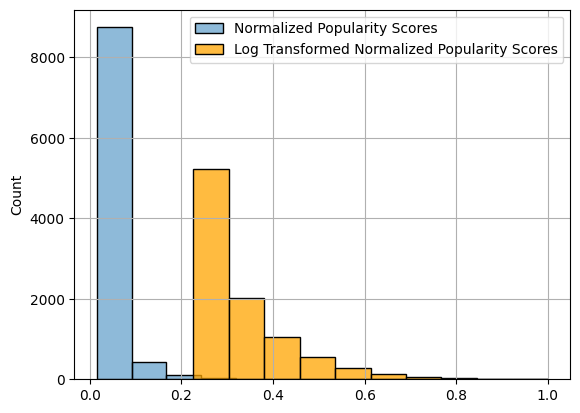

In [11]:
pop_val = [(row['popularity_norm'] for row in book_popularity.select('popularity_norm').collect())]
pop_val_log = [row['popularity_norm_log'] for row in book_popularity.select('popularity_norm_log').collect()]

sns.histplot(pop_val, bins=13, label='Normalized Popularity Scores', color='blue')
sns.histplot(pop_val_log, bins=10, label='Log Transformed Normalized Popularity Scores', color='orange')
plt.legend()
plt.grid()

Here the novelty score was computed using the log transformed normalization because the fractional normalization might not be an accuracy estimation due to how skewed the normalized ratings are. This could be due to how some of the books are being rated 2 times or even 10 times more than most of the other books. Log transformation reduces the gap between these difference better and thus giving a more realistic estimation on novelty on the ALS model.

In this ALS model, the novelty score is relatively high when compared to other metrics, indicating that this model recommends books that are mostly unpopular to the users.

#### Diversity score:

In [12]:
top_5_item_factors = best_model.itemFactors.filter(col('id').isin(top_5_ids)).collect() #Get the item factors for the top 5 books.

#convert to a list of (book_id, vector)
book_vec = [(row['id'], row['features']) for row in top_5_item_factors]

def cosine_similarity_cus(v1, v2):
    v1, v2 = np.array(v1), np.array(v2)
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

# Compute average similarity between all item pairs
similarities = []
for (id1, vec1), (id2, vec2) in combinations(book_vec, 2):
    sim = cosine_similarity_cus(vec1, vec2)
    similarities.append(sim)

avg_similarity = np.mean(similarities)
diversity_score_1 = 1 - avg_similarity


#### Serendipity score

In [13]:
#Find out items that the user has liked before (rated at least a 5 and above):
liked_items = train.filter((col('user_id') == user_id) & (col('rating') > 4)).select('book_id').collect()
liked_items_id = [row['book_id'] for row in liked_items] #Extract the book_id numbers from the liked items.

#Extract the item factors for the liked items:
liked_factors = best_model.itemFactors.filter(col('id').isin(liked_items_id)).collect() #Get the item factors for the liked items.
liked_vecs = [np.array(row['features']) for row in liked_factors] #Extracts the features from the liked items.

#compute cosine similarity between liked items and top 5 recommendations:
#average(1 - similarity) between top-5 and liked items
similarity = []

for rec_id, rec_vec in book_vec:
    rec_vec = np.array(rec_vec)
    
    for liked_vec in liked_vecs:
        #let's do cosine similarity:
        sim = cosine_similarity_cus(rec_vec, liked_vec) #computing two latent factor arrays
        similarity.append(1 - np.mean(sim)) #1 - similarity gives us the dissimilarity


serendipity_score_1 = np.mean(similarity)

print(f'Serendipity score: {serendipity_score_1:.4f}')
print(f"Diversity score : {diversity_score_1:.4f}")
print(f'Novelty score with log transformation normalization: {novelty_log:.3f}')

Serendipity score: 0.0930
Diversity score : 0.1107
Novelty score with log transformation normalization: 0.774


Since this ALS model does not offer too much of diversity and serendipity and keep recommending very similar items as shown by the low diversity score and high novelty score, we will try to compute the rating scores with a weighted approach to increase the diversity in recommending the books.

In [26]:
#Our target user is still defined as user_id = 5
#Let's get items that user_id = 5 has not rated
user_unrated = pred_mtx_unrated.filter(col('user_id') == user_id)

#Get the latent factors for the unrated
user_unrated_pd = user_unrated.join(
    best_model.itemFactors,
    user_unrated.book_id == best_model.itemFactors.id,
).select('user_id', 'book_id', 'prediction', 'features').toPandas()

#We will transition to Pandas and Numpy to compute serendipity:
liked_vecs_np = np.array(liked_vecs)

def serendipity_score(vec, liked_vecs):
    if vec is None or len(vec) == 0:
        return 1.0
    sims = []
    for liked_vec in liked_vecs:
        sim = cosine_similarity_cus(vec, liked_vec)
        sims.append(1 - sim)
    return np.mean(sims) if sim else 1.0

def diversity_score(vec, candidates_vecs):
    sims = []
    for cand_vec in candidates_vecs:
        sims.append(1 - cosine_similarity_cus(vec, cand_vec))
    return np.mean(sims) if sims else 1.0

top_vectors = [vec for _, vec in book_vec]

user_unrated_pd['serendipity'] = user_unrated_pd['features'].apply(lambda x: serendipity_score(x, liked_vecs_np))
user_unrated_pd['diversity'] = user_unrated_pd['features'].apply(lambda x: diversity_score(x, top_vectors))

user_unrated_pd.head(3)


,user_id,book_id,prediction,features,serendipity,diversity
0,5,70,6.754381,"[0.27637621760368347, 0.19430243968963623, 0.9...",0.109121,0.135654
1,5,190,5.908891,"[0.8992729187011719, 0.0, 1.0751075744628906, ...",0.226464,0.249618
2,5,203,7.301134,"[0.6150208115577698, 0.4731602072715759, 1.020...",0.063488,0.082773


Applying the adjusted scores:

In [15]:
#In here, alpha = prediction weights, beta = serendipity weights, gamma = diversity weights
#We can adjust these weights based on the importance we want to give to each factor.
alpha, beta, gamma = 0.5, 0.4, 0.1
user_unrated_pd['adjusted_score'] = (
    user_unrated_pd['prediction'] * alpha +
    user_unrated_pd['serendipity'] * beta +
    user_unrated_pd['diversity'] * gamma
)

top_5_reranked = user_unrated_pd.nlargest(5, 'adjusted_score')
print(f"Top 5 reranked recommendations for user_id = 5: {top_5_reranked[['book_id', 'adjusted_score']]}")

Top 5 reranked recommendations for user_id = 5:       book_id  adjusted_score
466      1154        5.329203
3873    12904        5.291413
5644    15412        5.214211
7064    10007        5.207173
4521    15537        5.178142


Re-calculating the Novelty, diversity, and serendipity scores:


In [16]:
topN_id = [np.int32(x) for x in top_5_reranked['book_id'].tolist()]
topN_vec = top_5_reranked['features'].tolist()

#Novelty score:
#We need to re-compute the book popularity to exclude extremely rare books.
book_popularity = train.groupBy('book_id').count()
max_count = book_popularity.agg(F.max('count')).collect()[0][0] #Get the max number of ratings for a book.
#In here we are normalizing the popularity scores in two ways:
book_popularity = book_popularity.withColumn('popularity_norm', col('count')/ F.lit(max_count))#Creates a normalized popularity column
book_popularity = book_popularity.withColumn('popularity_norm_log', log1p(col('count'))/ log1p(F.lit(max_count))) #Applying log transofmation to help center the distribution.

pop_df = book_popularity.toPandas()
topN_pop = pop_df[pop_df['book_id'].isin(topN_id)]

novelty_fraction = np.mean(1 - topN_pop['popularity_norm'])
novelty_log = np.mean(1 - topN_pop['popularity_norm_log'])


#Compute diversity score:
def compute_diversity(vectors):
    if len(vectors) < 2:
        return 1.0
    sims = [
        cosine_similarity_cus(v1, v2)
        for v1, v2 in combinations(vectors, 2)
    ]
    return 1 - np.mean(sims)

re_ranked_diversity_score = compute_diversity(topN_vec)

#Compute serendipity score:
def compute_serendipity(vectors, liked_vecs):
    serendipity_scores = []
    for vec in vectors:
        sims = [
            1 - cosine_similarity_cus(vec, liked_vec)
            for liked_vec in liked_vecs
        ]
        serendipity_scores.append(np.mean(sims))
    return np.mean(serendipity_scores)

re_ranked_serendipity_score = compute_serendipity(topN_vec, liked_vecs_np)

serendipity = compute_serendipity(topN_vec, liked_vecs_np)
print(f"re-ranked diversity score: {re_ranked_diversity_score:.4f}")
print(f"re-ranked serendipity score: {re_ranked_serendipity_score:.4f}")
print(f"Raw Diversity score: {diversity_score_1:.4f}")
print(f'Raw Serendipity score: {serendipity_score_1:.4f}')

re-ranked diversity score: 0.1107
re-ranked serendipity score: 0.0930
Raw Diversity score: 0.1107
Raw Serendipity score: 0.0930


By adjusting the diversity factor, we were able to increase the diversity score by a little without sacrificing user satistifcation. However, this adjustment seems to be very minimal considering there must be a balance between user satistifcation, diversity, and serendipity.

### Model 2: truncated SVD

In [17]:
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

Creating an empty matrix to store the predictions:

In [18]:
url = 'https://raw.githubusercontent.com/stormwhale/data-mines/refs/heads/main/book_rating.csv'
url2 = 'https://github.com/stormwhale/data-mines/raw/refs/heads/main/book_names.csv'
#Read the csv files:
rating = pd.read_csv(url, header='infer')
book_names = pd.read_csv(url2, header='infer', encoding='latin1')

#Renaming the column names:
rating.rename(columns={'user': 'user_id', 'item': 'book_id'}, inplace=True)
book_names = book_names.iloc[:,[0,2]]
book_names.rename(columns={'Book_ID': 'book_id', 'Book-Title': 'book_name'}, inplace=True)

#Merging the two into one dataframe:
df_com = pd.merge(rating, book_names, on='book_id', how='left')

# Map user/item IDs to continuous indices
user_ids = df_com["user_id"].unique()
item_ids = df_com["book_id"].unique()
user_map = {user: idx for idx, user in enumerate(user_ids)}
item_map = {item: idx for idx, item in enumerate(item_ids)}
df_com["user_idx"] = df_com["user_id"].map(user_map)
df_com["book_idx"] = df_com["book_id"].map(item_map)

num_users = len(user_ids)
num_items = len(item_ids)

#Add the normalized rating:
user_avg = df_com.groupby('user_id')['rating'].mean().reset_index()
#Add the user_avg_rating:
df_com['user_avg_rating'] = df_com['user_id'].map(user_avg.set_index('user_id')['rating'])
df_com['normalized_rating'] = df_com['rating'] - df_com['user_id'].map(user_avg.set_index('user_id')['rating'])

### Visualize the rating distribution:

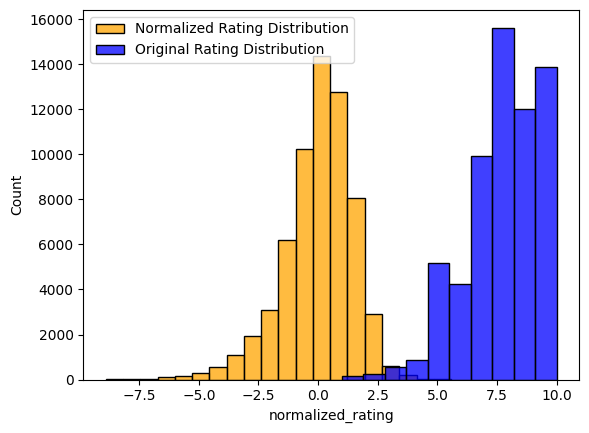

In [19]:
sns.histplot(df_com['normalized_rating'], bins=20, label='Normalized Rating Distribution', color='orange')
sns.histplot(df_com['rating'], bins=10, label='Original Rating Distribution', color='blue')
plt.legend()

### Train-test-split the data

In [20]:
train_svd, test_svd = train_test_split(df_com, test_size=0.2, random_state=42)
print(f'Total number of data in training: {train_svd.shape[0]}')
print(f'Total number of data in test: {test_svd.shape[0]}')

#To create a dense matrix for the training data:
train_row = train_svd['user_idx'].values
train_col = train_svd['book_idx'].values

Total number of data in training: 50124
Total number of data in test: 12532


Shape of the training matrix: (1295, 14684)
Best k: 165, Minmial RMSE: 1.4692
Minmial MAE: 1.1064


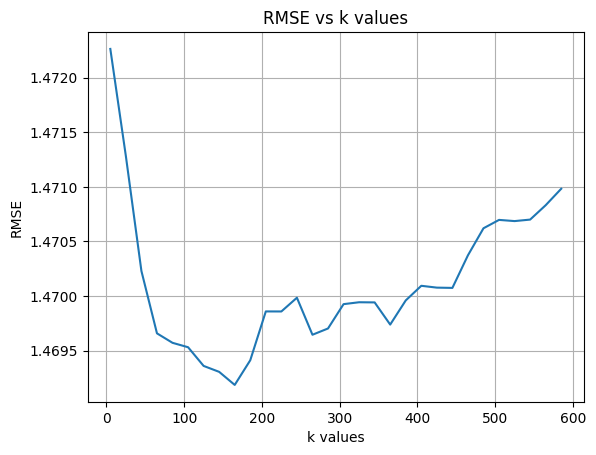

In [21]:
csr_train = csr_matrix((train_svd['normalized_rating'], (train_row, train_col)), shape=(num_users, num_items))
print(f"Shape of the training matrix: {csr_train.shape}")

#define the svd function:
def svd_decomp(csr_matrix, k):

    u_train, s_train, vt_train = svds(csr_matrix, k=k)

    #To reverse the array orders:
    u_train = u_train[:, ::-1]
    s_train = np.diag(s_train[::-1])
    vt_train = vt_train[::-1, :]

    return u_train, s_train, vt_train

#Tuning the k value:
k_train_values = []
rmse_train_values = []
mae_train_values = []
for k in range(5, 600, 20):
    csr_recon = svd_decomp(csr_train, k)
    csr_recon = np.dot(np.dot(csr_recon[0], csr_recon[1]), csr_recon[2])

    #predictions:
    pred_score = csr_recon[test_svd['user_idx'].values, test_svd['book_idx'].values]

    #Ground truth ratings:
    tru_ratings = test_svd['normalized_rating'].values

    #calculate RMSE and MAE
    svd_rmse = np.sqrt(mean_squared_error(tru_ratings, pred_score))
    svd_mae = np.mean(np.abs(tru_ratings - pred_score))

    k_train_values.append(k)
    rmse_train_values.append(svd_rmse)
    mae_train_values.append(svd_mae)

#Find the best k and the minmal RMSE and mae:
min_rmse = min(rmse_train_values)
min_mae = min(mae_train_values)
best_k_idx = rmse_train_values.index(min_rmse)
best_k = k_train_values[best_k_idx]
print(f'Best k: {best_k}, Minmial RMSE: {min_rmse:.4f}')
print(f'Minmial MAE: {min_mae:.4f}')

#Plot the RMSE values against k values:
sns.lineplot(x=k_train_values, y=rmse_train_values)
plt.xlabel('k values')
plt.ylabel('RMSE')
plt.title('RMSE vs k values')
plt.grid(True)


### Compute SVD with the tuned best k value:

In [22]:
#Creates the prediction matrix
svd_factors = svd_decomp(csr_train, best_k)



#Define the components of the SVD:
user_factor = svd_factors[0]
sigma = svd_factors[1]
item_factor = svd_factors[2]

pred_mtx = np.dot(np.dot(user_factor, sigma), item_factor)


In [23]:
#get top N recommendation for a specific user:
user_id = 5
# get a list of items that user has never rated before:
# We need to use the original user_id to filter, but then use the mapped user_idx for indexing csr_recon
user_idx = user_map[user_id]
rated_items_for_user = train_svd.loc[train_svd['user_id'] == user_id, 'book_idx'].values
all_item_indices = np.arange(num_items)
unrated_list_idx = np.setdiff1d(all_item_indices, rated_items_for_user)

#getting user predictions on these items:
pred_unrated = pred_mtx[user_idx, unrated_list_idx]

# Get the indices of the top 5 predicted ratings
top_5_indices_unrated = pred_unrated.argsort()[::-1][:5]

# Get the actual book_idx of the top 5 recommended books
recommended_book_idx = unrated_list_idx[top_5_indices_unrated]

# Map back to original book_id and get book names
recommended_book_ids = [item_ids[idx] for idx in recommended_book_idx]

# Get the book names for the recommended book_ids using df_com, then select relevant columns and drop duplicates
recommended_book_info_from_df_com = df_com[df_com['book_id'].isin(recommended_book_ids)]['book_name'].drop_duplicates()

#Get the indices of the recommended books specific to the selected user:
top_5_idx = recommended_book_info_from_df_com.index.values

#To append the predicted rating to df_com and add the user_avg_ratings back:
df_com['predicted_rating'] = pred_mtx[df_com['user_idx'].values, df_com['book_idx'].values] + df_com['user_avg_rating']

#To see the top 5 recommended books with the predicted ratings:
recommended_book_info_from_df_com = df_com.loc[top_5_idx, ['book_id', 'book_name', 'predicted_rating']].sort_values(by='predicted_rating', ascending=False)

print(f"Top 5 book recommendations for user {user_id}:")
display(recommended_book_info_from_df_com)


Top 5 book recommendations for user 5:


,book_id,book_name,predicted_rating
571,2438,Gifts of the Spirit : Living the Wisdom of the...,9.079093
390,132,Summer of Storms,7.244908
3169,1519,Don Quixote of LA Mancha,6.982640
2234,1630,Siddhartha,6.422977
3198,1011,The Phantom of the Opera (Signet Classics (Pap...,4.991599


In [24]:
#To generate novelty score:
#To get item popularity:
item_pop = df_com.groupby('book_id')['rating'].apply(lambda x: (x > 0).sum())
item_pop = item_pop / item_pop.max()
novelty_score = np.mean([1 - item_pop[i] for i in recommended_book_ids])
print(f'SVD model novelty score = {novelty_score}')

#To get the diversity score:
#Step 1 get item factors from the recommended items:
item_vec = item_factor[:, recommended_book_idx]
sim_matrix = cosine_similarity(item_vec.T) #.T is to put the rows as n items and k factors as columns. This is what the cosine_similarity takes
upper_triangle = sim_matrix[np.triu_indices(len(recommended_book_idx), k=1)]
diversity_score = 1 - np.mean(upper_triangle)
print(f'SVD model Diversity score = {diversity_score:.4f}')

#To get serendipity score:
#First get books_idx that the user rated a score 4 or above:
liked_items = df_com[(df_com['user_idx']==user_idx) & (df_com['rating'] >= 4)]
liked_book_indices = liked_items['book_idx'].unique()
#Extract the liked book factors:
liked_vec = item_factor[:, liked_book_indices]

serendipity_score = []

for i in recommended_book_idx:
  rec_vec = item_factor[:, i].reshape(1,-1)
  if liked_vec.shape[0] > 0:
    sim = cosine_similarity(rec_vec, liked_vec.T) # Transpose liked_vec here
    serendipity_score.append(1 - np.mean(sim))

serendipity = np.mean(serendipity_score)
print(f'SVD model Serendipity score = {serendipity:.4f}')

SVD model novelty score = 0.7325
SVD model Diversity score = 0.9697
SVD model Serendipity score = 0.9832


In [25]:
#Compare the metrics of the two models:
print(f'ALS model RMSE = {rmse_evaluator.evaluate(best_model.transform(test)):.4f}')
print(f'ALS model MAE = {mae_evaluator.evaluate(best_model.transform(test)):.4f}')
print(f'ALS model Novelty score with log transformation normalization: {novelty_log:.3f}')
print(f"ALS model Raw Diversity score: {diversity_score_1:.4f}")
print(f'ALS model Raw Serendipity score: {serendipity_score_1:.4f}')
print(f"ALS model re-ranked Diversity score: {re_ranked_diversity_score:.4f}")
print(f"ALS model re-ranked Serendipity score: {re_ranked_serendipity_score:.4f}")
print('-'*80)
print(f'SVD model RMSE: {min_rmse:.4f}')
print(f'SVD model MAE: {min_mae:.4f}')
print(f'SVD model novelty score = {novelty_score}')
print(f'SVD model Diversity score = {diversity_score:.4f}')
print(f'SVD model Serendipity score = {serendipity:.4f}')


ALS model RMSE = 1.7956
ALS model MAE = 1.4173
ALS model Novelty score with log transformation normalization: 0.824
ALS model Raw Diversity score: 0.1107
ALS model Raw Serendipity score: 0.0930
ALS model re-ranked Diversity score: 0.1107
ALS model re-ranked Serendipity score: 0.0930
--------------------------------------------------------------------------------
SVD model RMSE: 1.4692
SVD model MAE: 1.1064
SVD model novelty score = 0.7325
SVD model Diversity score = 0.9697
SVD model Serendipity score = 0.9832


### Conclusion:

Comparing the ALS model and the SVD model, the latter demonstrates superior performance in predicting user ratings. On both RMSE and MAE metrics, the SVD model yields lower error rates, indicating higher accuracy in capturing user preferences.

In terms of novelty, diversity, and serendipity, the ALS model has strengths in recommending less popular books, thereby offering users more novel experiences. However, it struggles with diversity and serendipity, often producing repetitive recommendations—reflected in its lower scores on these metrics. In contrast, the SVD model delivers more balanced recommendations. For the selected user, its top-5 recommendations are novel, diverse, and include items that are both unexpected and relevant, which can increase user engagement.

Attempts to enhance the ALS model by adjusting weight scores for improved diversity and serendipity yielded only minimal improvements. This highlights a limitation in ALS’s ability to escape popularity bias without more complex tuning or hybridization.

From a business perspective, the SVD model presents a more compelling choice. Its recommendations are less repetitive and more varied, including both mainstream and lesser-known books, which can improve user satisfaction and retention. Furthermore, its lower RMSE and MAE suggest better alignment with actual user ratings, potentially translating to improved click-through or purchase rates.

To further enhance the recommender system, online evaluation could be implemented, where key metrics such as accuracy, novelty, diversity, and serendipity are monitored in real time. One practical approach is to deploy both recommender systems in parallel and randomly assign users to each, enabling A/B testing. This would allow the collection of live feedback and performance data, enabling dynamic tuning of each model. However, such an approach requires substantial pre-deployment planning and infrastructure. Maintaining two live systems incurs higher operational costs, and the backend must be scalable to handle increased load.

In this context, deploying the system on a scalable cluster-based framework like Apache Spark on the cloud would be advantageous. Spark's distributed processing capabilities make it well-suited for high-volume, real-time recommendation workloads, especially when combined with robust orchestration tools and scalable cloud storage.
